In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

#check all the files in the input dataset
# print(os.listdir("../input/"))

2023-04-21 19:45:37.913293: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/ambrosedesmond/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Function to convert the astype of given colums

def astype_change(df,convert):
    """Function to change the astype of a given dataframe using a conversion dictionary"""
    df = df.astype(convert)
    return df

In [3]:
# pip install --upgrade tensorflow

In [4]:
df = pd.read_csv("time_series_60min_singleindex.csv")

In [5]:
df.tail()

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
50396,2020-09-30T19:00:00Z,2020-09-30T21:00:00+0200,6661.0,6656.0,NaN,NaN,1847.0,9402.0,9720.0,NaN,...,1506.95,1530.0,5.32,0.44,3324.0,3170.0,1.7,1.1,NaN,NaN
50397,2020-09-30T20:00:00Z,2020-09-30T22:00:00+0200,6336.0,6310.0,NaN,NaN,1723.0,9219.0,9418.0,NaN,...,1391.15,1388.0,5.57,0.62,3099.0,3010.0,1.7,1.0,NaN,NaN
50398,2020-09-30T21:00:00Z,2020-09-30T23:00:00+0200,5932.0,5813.0,NaN,NaN,1771.0,8763.0,8873.0,NaN,...,1250.17,1274.0,5.58,0.66,2940.0,2890.0,1.6,1.0,NaN,NaN
50399,2020-09-30T22:00:00Z,2020-10-01T00:00:00+0200,5628.0,5424.0,NaN,NaN,1779.0,8131.0,8285.0,NaN,...,1206.82,1178.0,5.61,0.21,2823.0,2740.0,1.7,1.2,NaN,NaN
50400,2020-09-30T23:00:00Z,2020-10-01T01:00:00+0200,5395.0,5204.0,NaN,NaN,1661.0,7837.0,7943.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# The dataset contains data from all European countries , will select only IE data
iedf = df[['utc_timestamp','IE_load_actual_entsoe_transparency', 'IE_wind_onshore_generation_actual']]


In [7]:
iedf.head()

,utc_timestamp,IE_load_actual_entsoe_transparency,IE_wind_onshore_generation_actual
0,2014-12-31T23:00:00Z,NaN,NaN
1,2015-01-01T00:00:00Z,2832.0,1336.0
2,2015-01-01T01:00:00Z,2678.0,1271.0
3,2015-01-01T02:00:00Z,2432.0,1244.0
4,2015-01-01T03:00:00Z,2276.0,1162.0


In [8]:
#convert date string  colum to datetime object
iedf[["utc_timestamp"]] = iedf[["utc_timestamp"]].apply(pd.to_datetime)

# I was attempting to convert the UTC time object to local time object but this proved
# very trickey so I opted to convert the other dataframe to UTC instead. Easier and same result.

#ddf[["date"]] = ddf[["date"]].apply(pd.to_datetime)
#iedf[["utc_timestamp"]]= pd.to_datetime(iedf["utc_timestamp"], format='%Y%m%d%H%M%S')

# df['DataFrame Column'] = pd.to_datetime(df['DataFrame Column'], format='%Y%m%d%H%M%S')
#iedf[['utc_timestamp']] = iedf[['utc_timestamp']].tz_localize('NONE')


#You should first specify that it is a datetime by adding the .dt. to a non index

#df['date'] = df['date'].dt.tz_localize('UTC').dt.tz_convert('Europe/Berlin')


/var/folders/7q/q53jnnsx3vs4q1f1p_k4f44w0000gn/T/ipykernel_38473/149408676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iedf[["utc_timestamp"]] = iedf[["utc_timestamp"]].apply(pd.to_datetime)


In [9]:
iedf.tail()

,utc_timestamp,IE_load_actual_entsoe_transparency,IE_wind_onshore_generation_actual
50396,2020-09-30 19:00:00+00:00,4070.0,493.0
50397,2020-09-30 20:00:00+00:00,3768.0,462.0
50398,2020-09-30 21:00:00+00:00,3382.0,395.0
50399,2020-09-30 22:00:00+00:00,3022.0,326.0
50400,2020-09-30 23:00:00+00:00,2854.0,250.0


Electricity consumption (load): forecast and actual values
wind and solar power: generation forecast, actual generation, installed capacity, capacity factors (profiles)
day-ahead spot prices

In [10]:
iedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   utc_timestamp                       50401 non-null  datetime64[ns, UTC]
 1   IE_load_actual_entsoe_transparency  49837 non-null  float64            
 2   IE_wind_onshore_generation_actual   50369 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 1.2 MB


In [11]:
iedf.head()

,utc_timestamp,IE_load_actual_entsoe_transparency,IE_wind_onshore_generation_actual
0,2014-12-31 23:00:00+00:00,NaN,NaN
1,2015-01-01 00:00:00+00:00,2832.0,1336.0
2,2015-01-01 01:00:00+00:00,2678.0,1271.0
3,2015-01-01 02:00:00+00:00,2432.0,1244.0
4,2015-01-01 03:00:00+00:00,2276.0,1162.0


In [12]:
# Checking for null data in my dataframe , there are quite a few.
iedf.isnull().sum()

utc_timestamp                           0
IE_load_actual_entsoe_transparency    564
IE_wind_onshore_generation_actual      32
dtype: int64

In [14]:
iedf.columns = ['date','load','wind_onshore']

In [15]:
# iedf21 = iedf[(iedf['time'] >= '2021-01-01') & (iedf['time'] <= '2021-12-31')]

In [16]:
# # Generate dataset
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [17]:
# because the data set is hourley with sparce nulls , I opted for a ffill forward option.
# I will need to test the effect of this option on the dataset and compare it to other fill options 

iedf = iedf.ffill()

# df_ffill['load'].plot(title='Forward Fill', ax=axes[1], label='Forward Fill', style=".-")


In [18]:
# Nulls are gone
iedf.isnull().sum()

date            0
load            1
wind_onshore    1
dtype: int64

<AxesSubplot:>

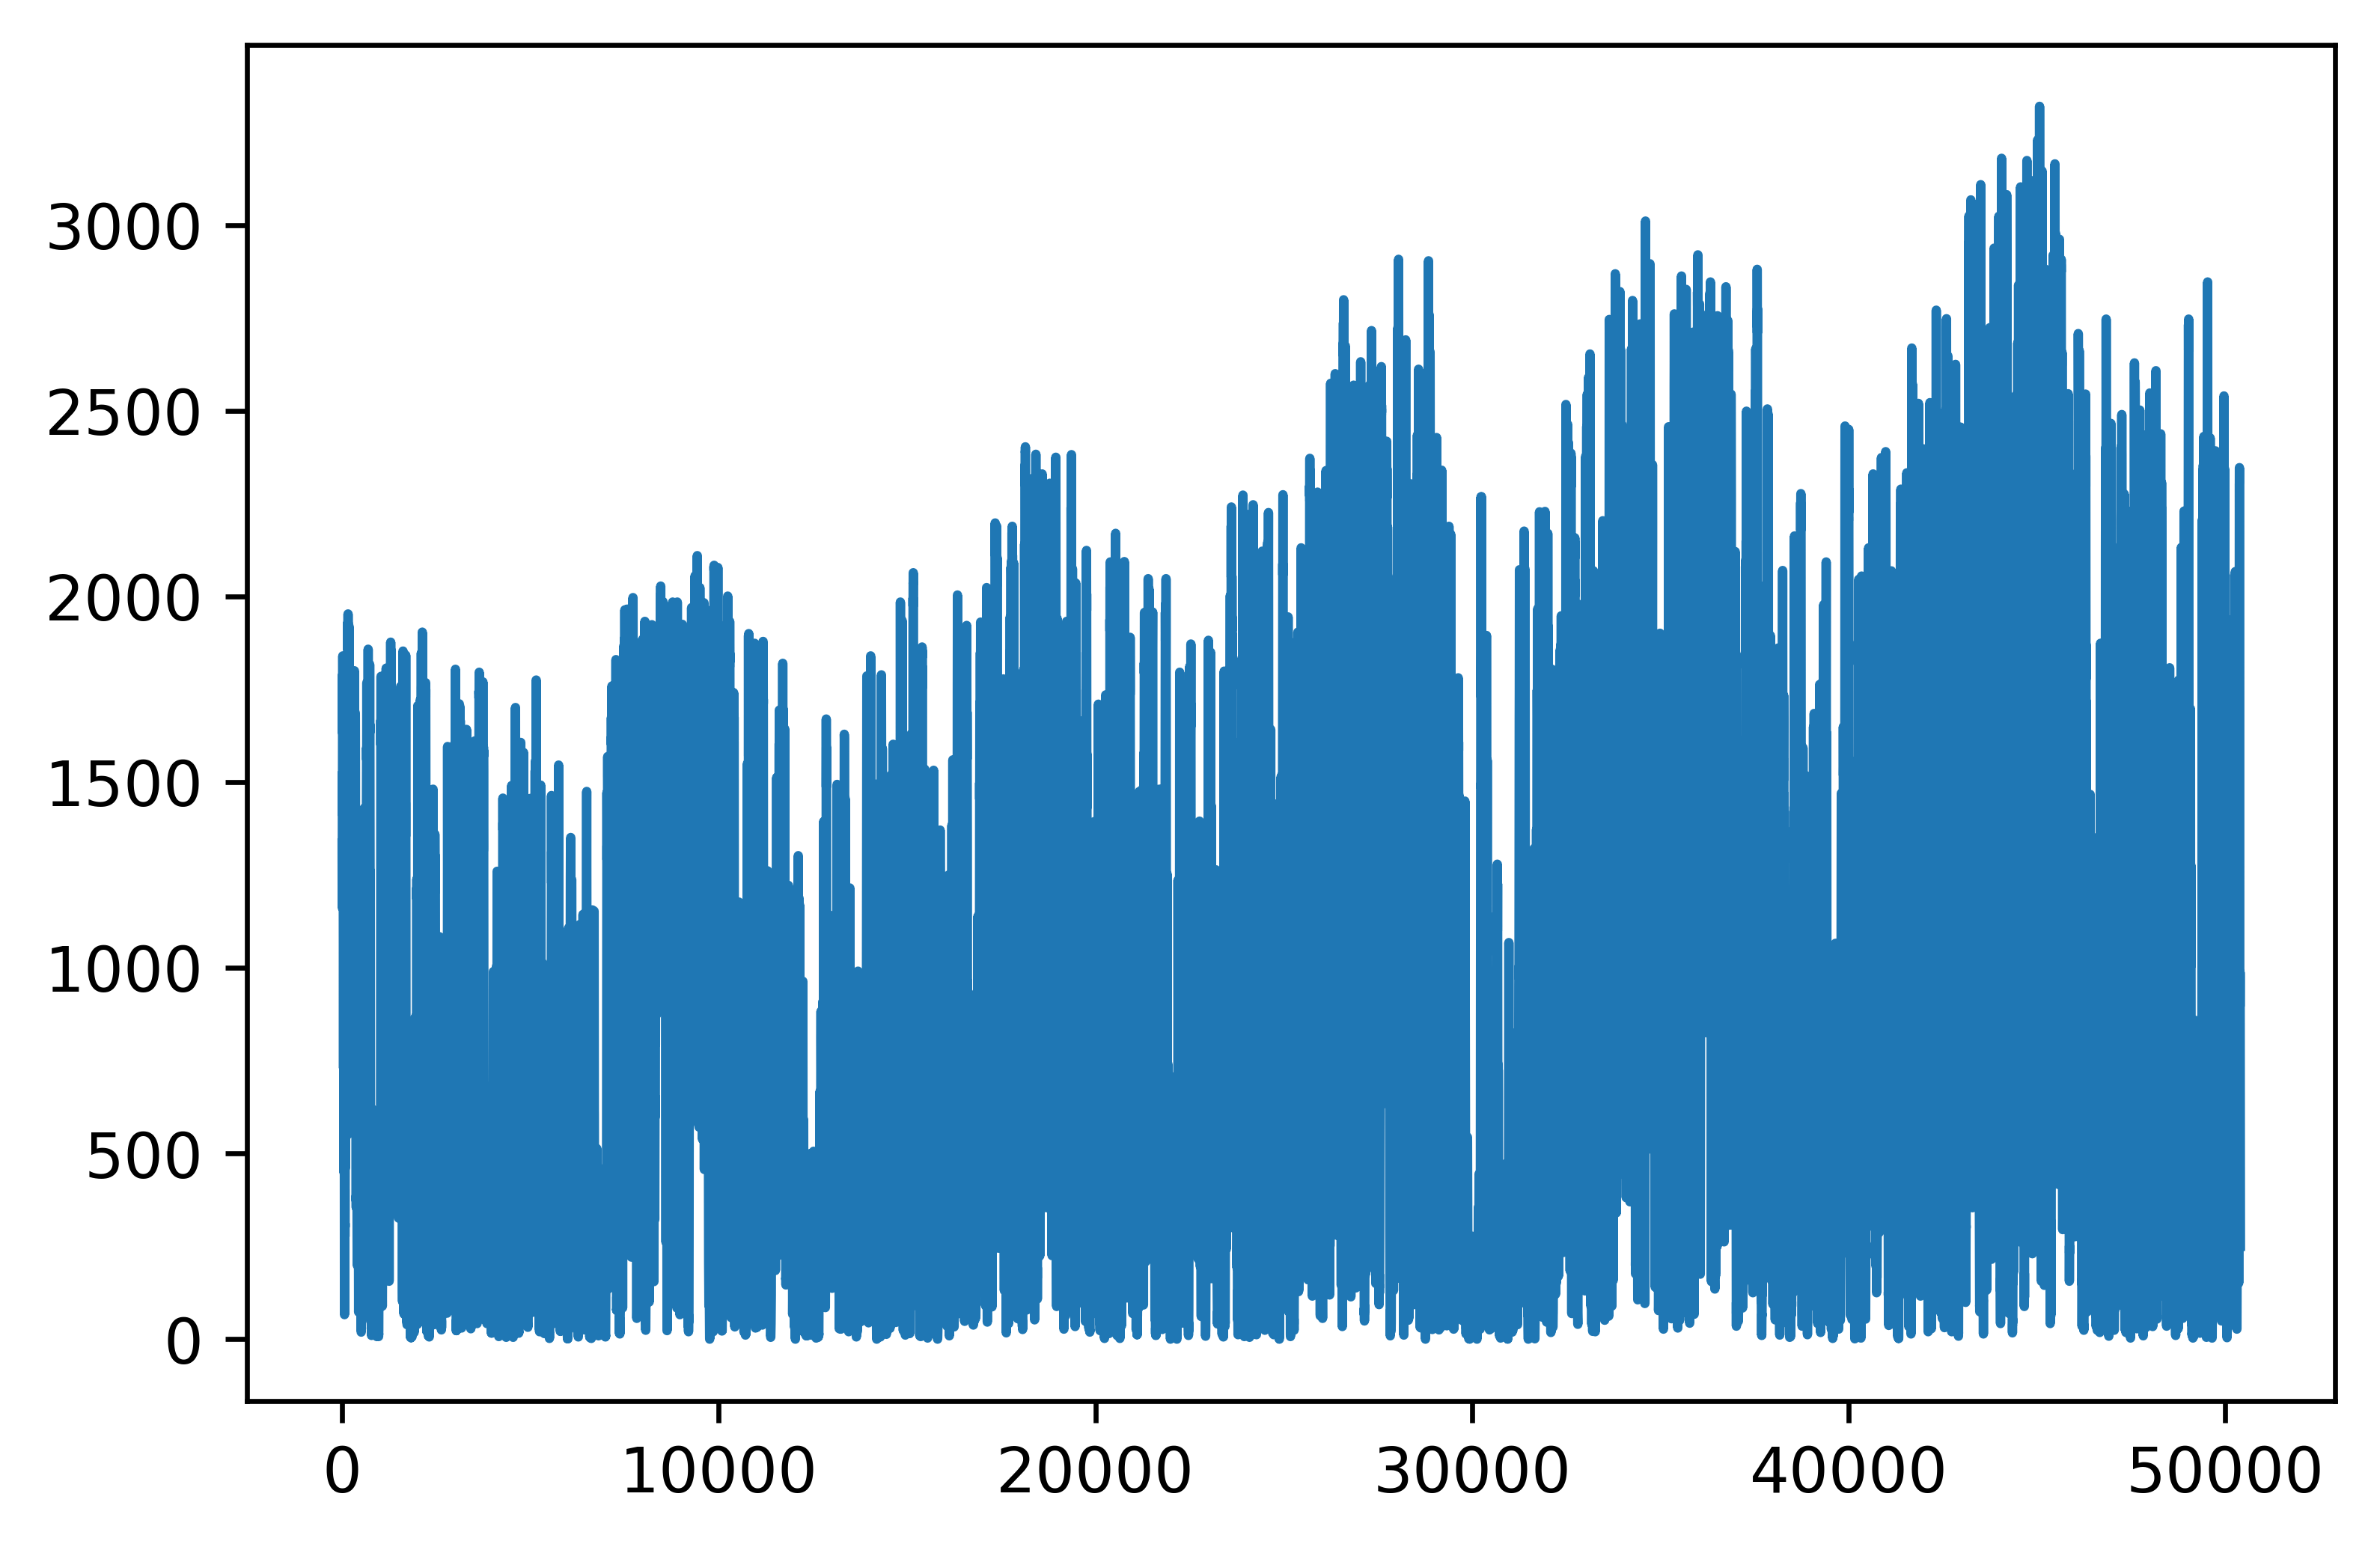

In [20]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(dpi=600)
iedf.wind_onshore.plot()

In [21]:
wdf = pd.read_csv("hly3904.csv", skiprows=23)

/var/folders/7q/q53jnnsx3vs4q1f1p_k4f44w0000gn/T/ipykernel_38473/1941139649.py:1: DtypeWarning: Columns (2,6,8,9,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  wdf = pd.read_csv("hly3904.csv", skiprows=23)


date:  -  Date and Time (utc)
rain:  -  Precipitation Amount (mm)	  
temp:  -  Air Temperature (C)	
wetb:  -  Wet Bulb Temperature (C)
dewpt: -  Dew Point Temperature (C)             
rhum:  -  Relative Humidity (%)
vappr: -  Vapour Pressure (hPa)	 
msl:   -  Mean Sea Level Pressure (hPa)
wdsp:  -  Mean Wind Speed (knot)
wddir: -  Predominant Wind Direction (degree)
ww:    -  Synop code for Present Weather
w:     -  Synop code for Past Weather
sun:   -  Sunshine duration (hours)
vis:   -  Visibility (m)
clht:  -  Cloud height (100's of ft) - 999 if none 
clamt: -  Cloud amount
ind:   -  Indicator

In [22]:
wdf.tail()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
536875,31-mar-2023 20:00,3,0.0,0,9.2,0,8.0,6.7,9.8,84,...,2,10,2,280,2,11,0.0,35000,200,4
536876,31-mar-2023 21:00,3,0.0,0,8.5,0,7.4,6.1,9.4,85,...,2,10,2,260,2,11,0.0,35000,999,1
536877,31-mar-2023 22:00,3,0.0,0,7.2,0,6.4,5.4,9.0,88,...,2,7,2,250,2,11,0.0,35000,999,1
536878,31-mar-2023 23:00,3,0.0,0,7.3,0,6.7,6.0,9.3,91,...,2,8,2,260,2,11,0.0,35000,200,4
536879,01-apr-2023 00:00,3,0.0,0,7.0,0,6.3,5.5,9.0,90,...,2,9,2,260,2,11,0.0,35000,999,1


In [23]:
iedf.head()

,date,load,wind_onshore
0,2014-12-31 23:00:00+00:00,NaN,NaN
1,2015-01-01 00:00:00+00:00,2832.0,1336.0
2,2015-01-01 01:00:00+00:00,2678.0,1271.0
3,2015-01-01 02:00:00+00:00,2432.0,1244.0
4,2015-01-01 03:00:00+00:00,2276.0,1162.0


In [24]:
iedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          50401 non-null  datetime64[ns, UTC]
 1   load          50400 non-null  float64            
 2   wind_onshore  50400 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 1.2 MB


In [25]:
# Converting the date column to UTC to match the other dataframe 
# because this will allow a merge on the two dataframes on the  datetime index
wdf[["date"]] = wdf[['date']].apply(pd.to_datetime, utc = True)

In [27]:
# Drop the indicator columns as they dont apply here
wdf = wdf.drop(['ind','ind.1','ind.2','ind.3','ind.4'], axis=1)


In [28]:
# Checking for null values
wdf.isnull().sum()

date     0
rain     0
temp     0
wetb     0
dewpt    0
vappr    0
rhum     0
msl      0
wdsp     0
wddir    0
ww       0
w        0
sun      0
vis      0
clht     0
clamt    0
dtype: int64

In [29]:
wdf.head()

,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt
0,1962-01-01 01:00:00+00:00,,-1.1,-1.3,-1.6,5.3,94,1016.0,14,340,2,0,,30000,999,2
1,1962-01-01 02:00:00+00:00,,-1.1,-1.3,-1.6,5.3,94,1016.5,10,340,3,1,,30000,20,7
2,1962-01-01 03:00:00+00:00,,-1.0,-1.2,-1.6,5.3,94,1016.7,12,320,1,1,,30000,999,3
3,1962-01-01 04:00:00+00:00,,-1.6,-1.8,-2.2,5.1,94,1017.2,8,330,1,0,,30000,999,1
4,1962-01-01 05:00:00+00:00,,-2.1,-2.3,-3.3,4.8,93,1018.0,11,320,1,0,,30000,999,0


In [30]:
# looking at each info of my columns to see if they are in the correct astype.
# date is a date time object , windspeed is a n int64
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536880 entries, 0 to 536879
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype              
---  ------  --------------   -----              
 0   date    536880 non-null  datetime64[ns, UTC]
 1   rain    536880 non-null  object             
 2   temp    536880 non-null  float64            
 3   wetb    536880 non-null  object             
 4   dewpt   536880 non-null  float64            
 5   vappr   536880 non-null  object             
 6   rhum    536880 non-null  object             
 7   msl     536880 non-null  float64            
 8   wdsp    536880 non-null  int64              
 9   wddir   536880 non-null  int64              
 10  ww      536880 non-null  int64              
 11  w       536880 non-null  int64              
 12  sun     536880 non-null  object             
 13  vis     536880 non-null  object             
 14  clht    536880 non-null  object             
 15  clamt   536880 non-null  object   

In [31]:
# Selecting the date a 5 year date range for both data frames
wdf15 = wdf[(wdf['date'] >= '2015-01-01') & (wdf['date'] <= '2019-12-31')]
iedf15 = iedf[(iedf['date'] >= '2015-01-01') & (iedf['date'] <= '2019-12-31')]

In [32]:
# wdf['clht'] = wdf['clht'].astype(float)
# wdf['clamt'] = wdf['clamt'].astype(float)

In [33]:
# Set the index in both dataframes to datetime
wdf15 = wdf15[wdf15['date'].notnull() == True].set_index('date')
iedf15 = iedf15[iedf15['date'].notnull() == True].set_index('date')

In [34]:
# perform a join on both datasets on the date index
iedw = wdf15.join(iedf15)

In [35]:
iedw.tail()

,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,load,wind_onshore
date,,,,,,,,,,,,,,,,,
2019-12-30 20:00:00+00:00,0.2,9.1,9.0,8.8,11.4,99,1027.4,2,120,50,54,0.0,800,1,8,3642.0,603.0
2019-12-30 21:00:00+00:00,0.0,9.1,9.0,8.8,11.4,99,1027.3,3,70,42,54,0.0,900,1,8,3462.0,739.0
2019-12-30 22:00:00+00:00,0.0,9.1,9.0,8.9,11.4,99,1027.7,4,70,46,44,0.0,500,1,8,3243.0,716.0
2019-12-30 23:00:00+00:00,0.1,8.9,8.9,8.8,11.4,100,1027.7,5,110,50,54,0.0,1200,2,7,3128.0,890.0
2019-12-31 00:00:00+00:00,0.1,8.7,8.6,8.5,11.1,99,1027.8,5,100,50,54,0.0,2200,2,7,2923.0,1004.0


In [36]:
# Check the sahape of the new dataframe
iedw.shape

(43801, 17)

In [37]:
# Checking for any null values
iedw.isnull().sum()

rain            0
temp            0
wetb            0
dewpt           0
vappr           0
rhum            0
msl             0
wdsp            0
wddir           0
ww              0
w               0
sun             0
vis             0
clht            0
clamt           0
load            0
wind_onshore    0
dtype: int64

In [38]:
# using rcParams to make the following graphs bigger as thay contain a lot of detail
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8

<AxesSubplot:>

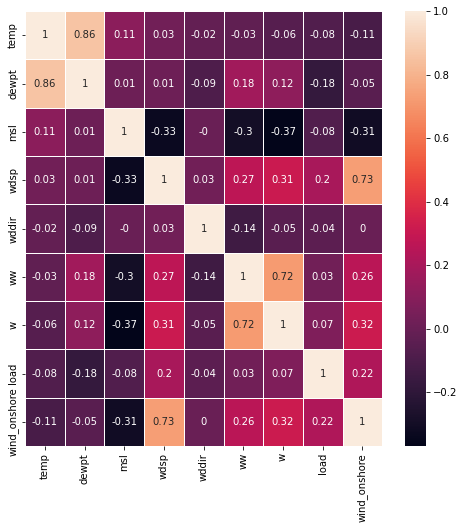

In [39]:
# Checking the corrolation matrix 
import seaborn as sns
plt.figure(figsize=(8, 8))
cor_matrix = iedw.corr().round(2)
sns.heatmap(data = cor_matrix, annot=True,linewidths=.5)
# plt.savefig("heatmap_1.png", dpi=300)
# Wind speed and onshore_wind have a hig .72 correlation
# and load has the highst correlation with the dew point and wind speed

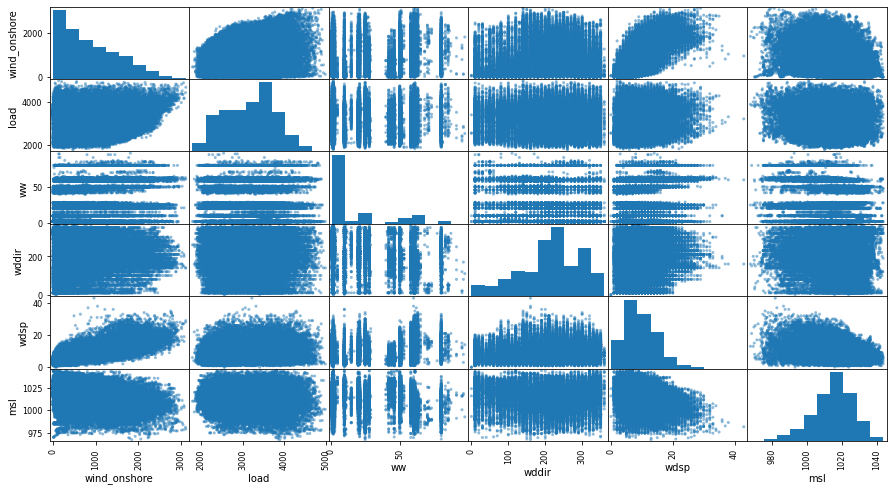

In [40]:
# from the scatter plot Load and msl look to be the closest to normally distributed
# and wind speed and wind onshore look to have a linera relationship.
# will investigate this further in the next stage.
from pandas.plotting import scatter_matrix
features = ['wind_onshore','load','ww','wddir','wdsp','msl','rain']

scatter_matrix(iedw[features]);
# plt.savefig("scat_matrix_limited.png", dpi=300);
#plt.show()

In [41]:
iedw.to_csv('IE_Energy_Weather.csv')

In [42]:
iedw.head()

,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,load,wind_onshore
date,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,9.8,9.8,9.8,12.1,100,1023.4,9,200,2,65,0.0,25000,2,8,2832.0,1336.0
2015-01-01 01:00:00+00:00,0.0,9.8,9.8,9.8,12.1,100,1023.4,12,210,2,11,0.0,25000,5,8,2678.0,1271.0
2015-01-01 02:00:00+00:00,0.0,9.2,9.2,9.2,11.6,100,1023.2,9,210,2,11,0.0,25000,4,8,2432.0,1244.0
2015-01-01 03:00:00+00:00,0.0,8.9,8.9,8.9,11.4,100,1022.4,7,180,2,11,0.0,30000,80,5,2276.0,1162.0
2015-01-01 04:00:00+00:00,0.0,9.3,9.3,9.3,11.7,100,1020.9,10,190,2,11,0.0,25000,4,8,2173.0,1182.0


In [43]:
# made mini file for cassandra demo
IE_Energy_Weather_demo = iedw.drop(['rain','wetb','dewpt','rhum','msl','wdsp','ww','w','sun','vis','clht','clamt'], axis=1)

In [44]:
IE_Energy_Weather_demo.head()

,temp,vappr,wddir,load,wind_onshore
date,,,,,
2015-01-01 00:00:00+00:00,9.8,12.1,200,2832.0,1336.0
2015-01-01 01:00:00+00:00,9.8,12.1,210,2678.0,1271.0
2015-01-01 02:00:00+00:00,9.2,11.6,210,2432.0,1244.0
2015-01-01 03:00:00+00:00,8.9,11.4,180,2276.0,1162.0
2015-01-01 04:00:00+00:00,9.3,11.7,190,2173.0,1182.0


In [45]:
IE_Energy_Weather_demo.to_csv('IE_Energy_Weather_demo.csv')